# **Data import & import**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/AI hackathon/data/')

In [16]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.integrate import cumtrapz
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

train_features =pd.read_csv('train_features.csv')
train_labels = pd.read_csv('train_labels.csv')
test = pd.read_csv('test_features.csv')
submission = pd.read_csv('sample_submission.csv')

# **Data Observation**
index 26 : Non-Exercise 

id, 600

train data 3125

test data 782



In [8]:
train_features

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234
...,...,...,...,...,...,...,...,...
1874995,3124,595,-0.712530,-0.658357,0.293707,-29.367857,-104.013664,-76.290437
1874996,3124,596,-0.683037,-0.658466,0.329223,-30.149089,-101.796809,-76.625087
1874997,3124,597,-0.664730,-0.666625,0.364114,-27.873095,-98.776072,-79.365125
1874998,3124,598,-0.630534,-0.682565,0.373696,-23.636550,-99.139495,-80.259478


In [9]:
#id 별로 각각 600개의 데이터가 있음을 확인   
train_features['id'].value_counts()

2047    600
1347    600
2378    600
1354    600
2379    600
       ... 
1699    600
675     600
2722    600
1698    600
0       600
Name: id, Length: 3125, dtype: int64

In [10]:
#train_labels.csv 에서 id 가 수행한 동작과 그에 따른 label값을 확인
train_labels

,id,label,label_desc
0,0,37,Shoulder Press (dumbbell)
1,1,26,Non-Exercise
2,2,3,Biceps Curl (band)
3,3,26,Non-Exercise
4,4,26,Non-Exercise
...,...,...,...
3120,3120,26,Non-Exercise
3121,3121,26,Non-Exercise
3122,3122,15,Dynamic Stretch (at your own pace)
3123,3123,26,Non-Exercise


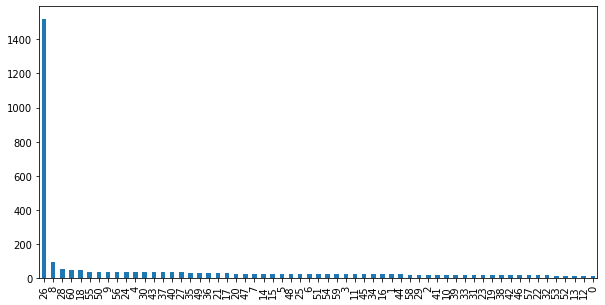

In [11]:
# 26번 데이터는 Non-Exercise data로 train 데이터의 절반 이상을 차지하고 있다
plt.figure(figsize=(10,5))
train_labels['label'].value_counts().plot(kind='bar')

# **Data Preprocessing**
data split

*  X_train_acc, X_train_gy 
*  X_test_acc, X_test_gy
*  acc_list, gy_list => act_list(acc + gy) 
*  


In [20]:
# 데이터 분할
act_list = train_features.iloc[:,2:].columns
acc_list = ['acc_x','acc_y','acc_z']
gy_list = ['gy_x','gy_y','gy_z']
act_list

Index(['acc_x', 'acc_y', 'acc_z', 'gy_x', 'gy_y', 'gy_z'], dtype='object')

In [21]:
# acceleromete, gyroscope sensor feature split
def sensor_split(data):
  X_acc = []
  X_gy = []

  for i in tqdm(data['id'].unique()):
      temp_acc = np.array(data[data['id'] == i].loc[:,acc_list])
      temp_gy = np.array(data[data['id'] == i].loc[:,gy_list])
      X_acc.append(temp_acc)
      X_gy.append(temp_gy)
      
  X_acc = np.array(X_acc).reshape(-1,600,3)
  X_gy = np.array(X_gy).reshape(-1,600,3)

  return X_acc, X_gy

In [22]:
X_train_acc, X_train_gy = sensor_split(train_features)

X_test_acc, X_test_gy = sensor_split(test)

100%|██████████| 782/782 [00:03<00:00, 235.45it/s]


# **Data Scaling**
*   StandardScaler
*   RobustScaler
*   MinMaxScaler
*   Normalizer

In [23]:
# Scaling 
# sklearn 의 data preprocessing - sklearn에서 제공하는 기본 스케일러 중 하나 
scaler = StandardScaler()
#scaler = RobustScaler()
train_features[act_list] = scaler.fit_transform(train_features[act_list])
test[act_list] = scaler.transform(test[act_list])
train_features

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,2.307314,-0.029939,-0.432104,0.011776,-0.410859,-0.461007
1,0,1,2.421086,-0.063321,-0.504058,0.026484,-0.528052,-0.365459
2,0,2,2.444664,-0.056749,-0.654199,-0.037962,-0.596041,-0.366767
3,0,3,2.428612,-0.116782,-0.573407,0.066099,-0.725311,-0.401232
4,0,4,2.439475,-0.044220,-0.588886,0.091969,-0.784094,-0.408413
...,...,...,...,...,...,...,...,...
1874995,3124,595,-0.367432,-0.845648,0.503707,-0.461266,-1.413128,-1.092639
1874996,3124,596,-0.326315,-0.845833,0.578875,-0.474109,-1.382884,-1.097377
1874997,3124,597,-0.300794,-0.859728,0.652722,-0.436694,-1.341672,-1.136169
1874998,3124,598,-0.253120,-0.886873,0.673002,-0.367051,-1.346630,-1.148831


# **Data Augmentation**

time warping, permutation...

In [24]:
# 데이터 증강

# Time Warping
sigma = 0.2
knot = 4

def GenerateRandomCurves(X, sigma=0.2, knot=4):
    xx = (np.ones((X.shape[1],1))*(np.arange(0,X.shape[0], (X.shape[0]-1)/(knot+1)))).transpose()
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot+2, X.shape[1]))
    x_range = np.arange(X.shape[0])
    cs_x = CubicSpline(xx[:,0], yy[:,0])
    cs_y = CubicSpline(xx[:,1], yy[:,1])
    cs_z = CubicSpline(xx[:,2], yy[:,2])
    return np.array([cs_x(x_range),cs_y(x_range),cs_z(x_range)]).transpose()

def DistortTimesteps(X, sigma):
    tt = GenerateRandomCurves(X, sigma) # Regard these samples aroun 1 as time intervals
    tt_cum = np.cumsum(tt, axis=0)        # Add intervals to make a cumulative graph
    # Make the last value to have X.shape[0]
    t_scale = [(X.shape[0]-1)/tt_cum[-1,0],(X.shape[0]-1)/tt_cum[-1,1],(X.shape[0]-1)/tt_cum[-1,2]]
    tt_cum[:,0] = tt_cum[:,0]*t_scale[0]
    tt_cum[:,1] = tt_cum[:,1]*t_scale[1]
    tt_cum[:,2] = tt_cum[:,2]*t_scale[2]
    return tt_cum

def TimeWarp(X, sigma):
    tt_new = DistortTimesteps(X, sigma)
    X_new = np.zeros(X.shape)
    x_range = np.arange(X.shape[0])
    X_new[:,0] = np.interp(x_range, tt_new[:,0], X[:,0])
    X_new[:,1] = np.interp(x_range, tt_new[:,1], X[:,1])
    X_new[:,2] = np.interp(x_range, tt_new[:,2], X[:,2])
    return X_new

# Permutation
def Permutation(X, nPerm=4, minSegLength=10):
    X_new = np.zeros(X.shape)
    idx = np.random.permutation(nPerm)
    bWhile = True
    while bWhile == True:
        segs = np.zeros(nPerm+1, dtype=int)
        segs[1:-1] = np.sort(np.random.randint(minSegLength, X.shape[0]-minSegLength, nPerm-1))
        segs[-1] = X.shape[0]
        if np.min(segs[1:]-segs[0:-1]) > minSegLength:
            bWhile = False
    pp = 0
    for ii in range(nPerm):
        x_temp = X[segs[idx[ii]]:segs[idx[ii]+1],:]
        X_new[pp:pp+len(x_temp),:] = x_temp
        pp += len(x_temp)
    return (X_new)

# Rotation
def Rotation(X):
    axis = np.random.uniform(low=-1, high=1, size=X.shape[1])
    angle = np.random.uniform(low=-np.pi, high=np.pi)
    return np.matmul(X , axangle2mat(axis,angle))

# Jittering
def Jitter(X, sigma=0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X+myNoise

# Magnitude Warping
def MagWarp(X, sigma):
    return X * GenerateRandomCurves(X, sigma)

def rolling(data):
    aug_data=[]
    for i in range(data.shape[0]):
        temp=list((aug(data,i,int(random.random()*600))))
        aug_data.append(temp)
    return np.array(aug_data)

def aug(data, uid, shift):
    shift_data = np.roll(data[uid], shift, axis=0)
    return shift_data

In [25]:
def ts_aug(data, method,sigma):
  new_data=[]
  for i in range(data.shape[0]):
    temp=list(method(data[i], sigma))
    new_data.append(temp)
  return np.array(new_data)

In [26]:
X_train_acc_comb = Permutation(Jitter(X_train_acc))
X_train_acc_perm = Permutation(X_train_acc)
X_train_acc_timew = ts_aug(X_train_acc, TimeWarp, 0.2)
X_train_acc_magw = ts_aug(X_train_acc, MagWarp, 0.2)

X_train_gy_comb = Permutation(Jitter(X_train_gy))
X_train_gy_perm = Permutation(X_train_gy)
X_train_gy_timew = ts_aug(X_train_gy, TimeWarp, 0.2)
X_train_gy_magw = ts_aug(X_train_gy, MagWarp, 0.2)

In [27]:
X_train_acc = np.append(X_train_acc, X_train_acc_comb, axis=0)
X_train_acc = np.append(X_train_acc, X_train_acc_perm, axis=0)
X_train_acc = np.append(X_train_acc, X_train_acc_timew, axis=0)
X_train_acc = np.append(X_train_acc, X_train_acc_magw, axis=0)

X_train_gy = np.append(X_train_gy, X_train_gy_comb, axis=0)
X_train_gy = np.append(X_train_gy, X_train_gy_perm, axis=0)
X_train_gy = np.append(X_train_gy, X_train_gy_timew, axis=0)
X_train_gy = np.append(X_train_gy, X_train_gy_magw, axis=0)

In [28]:
acc = [e for sl in X_train_acc for e in sl]

df_report = np.stack(acc, axis = 0)
df_acc = pd.DataFrame(df_report, columns= ['acc_x', 'acc_y', 'acc_z'])

df_acc

,acc_x,acc_y,acc_z
0,1.206087,-0.179371,-0.148447
1,1.287696,-0.198974,-0.182444
2,1.304609,-0.195114,-0.253382
3,1.293095,-0.230366,-0.215210
4,1.300887,-0.187757,-0.222523
...,...,...,...
9374995,-0.879796,-0.493945,0.220293
9374996,-0.848086,-0.494723,0.243871
9374997,-0.829988,-0.501607,0.266263
9374998,-0.791733,-0.514422,0.269655


In [29]:
# gy

gy = [e for sl in X_train_gy for e in sl]

df_report = np.stack(gy, axis = 0)
df_gy = pd.DataFrame(df_report, columns= ['gy_x', 'gy_y', 'gy_z'])

df_gy

,gy_x,gy_y,gy_z
0,-0.591608,-30.549010,-31.676112
1,0.303100,-39.139103,-24.927216
2,-3.617278,-44.122565,-25.019629
3,2.712986,-53.597843,-27.454013
4,4.286707,-57.906561,-27.961234
...,...,...,...
9374995,-28.618873,-77.303716,-81.978320
9374996,-29.413057,-75.442751,-81.939167
9374997,-27.224101,-72.996087,-84.451567
9374998,-23.113813,-73.055011,-84.976141


In [30]:
# acc, gy 데이터프레임 병합

df_aug_result = pd.concat([df_acc, df_gy], axis = 1)
df_aug_result.insert(0, 'id', 0)
df_aug_result.insert(1, 'time', 1)
df_aug_result

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,1,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,1,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,1,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,1,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234
...,...,...,...,...,...,...,...,...
9374995,0,1,-0.879796,-0.493945,0.220293,-28.618873,-77.303716,-81.978320
9374996,0,1,-0.848086,-0.494723,0.243871,-29.413057,-75.442751,-81.939167
9374997,0,1,-0.829988,-0.501607,0.266263,-27.224101,-72.996087,-84.451567
9374998,0,1,-0.791733,-0.514422,0.269655,-23.113813,-73.055011,-84.976141


In [31]:
df_aug_result.loc[600*0:600*0+600, 'time']

0      1
1      1
2      1
3      1
4      1
      ..
596    1
597    1
598    1
599    1
600    1
Name: time, Length: 601, dtype: int64

In [32]:
train = df_aug_result
train

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,1,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,1,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,1,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,1,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234
...,...,...,...,...,...,...,...,...
9374995,0,1,-0.879796,-0.493945,0.220293,-28.618873,-77.303716,-81.978320
9374996,0,1,-0.848086,-0.494723,0.243871,-29.413057,-75.442751,-81.939167
9374997,0,1,-0.829988,-0.501607,0.266263,-27.224101,-72.996087,-84.451567
9374998,0,1,-0.791733,-0.514422,0.269655,-23.113813,-73.055011,-84.976141


In [33]:
n = 4
train_labels_copy = train_labels.copy()
for i in range(0, n):
    train_labels = train_labels.append(train_labels_copy, ignore_index=True)
train_labels = train_labels.reset_index()
train_labels

,index,id,label,label_desc
0,0,0,37,Shoulder Press (dumbbell)
1,1,1,26,Non-Exercise
2,2,2,3,Biceps Curl (band)
3,3,3,26,Non-Exercise
4,4,4,26,Non-Exercise
...,...,...,...,...
15620,15620,3120,26,Non-Exercise
15621,15621,3121,26,Non-Exercise
15622,15622,3122,15,Dynamic Stretch (at your own pace)
15623,15623,3123,26,Non-Exercise


# **속도, 각속도 추가**

In [ ]:
# 속도, 각속도 추가
feature_names = ['acc_x','acc_y','acc_z','gy_x','gy_y','gy_z']

grad_cols=[]
for col in feature_names:
    grad_cols.append(f"grad_{col}")

integ_cols = []
for col in feature_names:
    integ_cols.append(f"integ_{col}")
    
total_feature_names = feature_names + grad_cols + integ_cols

for uid in tqdm(train['id'].unique()):
    temp = train.loc[train['id']==uid, feature_names]
    grad = np.gradient(temp, axis=0)
    train.loc[train['id']==uid, grad_cols] = grad
    
for uid in tqdm(test['id'].unique()):
    temp = test.loc[test['id']==uid, feature_names]
    grad = np.gradient(temp, axis=0)
    test.loc[test['id']==uid, grad_cols] = grad
    
print(train.shape, test.shape)
train.head()

for uid in tqdm(train['id'].unique()):
    temp = train.loc[train['id']==uid, feature_names]
    integ = cumtrapz(temp, initial=0, axis=0)
    train.loc[train['id']==uid, integ_cols] = integ
    
for uid in tqdm(test['id'].unique()):
    temp = test.loc[test['id']==uid, feature_names]
    integ = cumtrapz(temp, initial=0, axis=0)
    test.loc[test['id']==uid, integ_cols] = integ
    
print(train.shape, test.shape)
train

 12%|█▏        | 837/6707 [06:27<45:20,  2.16it/s]


KeyboardInterrupt: ignored

In [ ]:
# 가속도 feature 추가
train['acc_t']  = train.apply(lambda x : (x['acc_x']**2 + x['acc_y'] **2 +  x['acc_z'] ** 2 )**(1/3), axis=1)
test['acc_t']  = test.apply(lambda x : (x['acc_x']**2 + x['acc_y'] **2 +  x['acc_z'] ** 2 )**(1/3), axis=1)

display(train)
display(test)

KeyboardInterrupt: ignored

In [ ]:
out_list = []
for i in range(3125):
  label = train_label.loc[(train_label['id'] == i),'label'].values[0,1] 
  out_list.append(label)

out_list = np.array(out_list)
#out_list = np.expand_dims(np.array(out_list), axis = 1)
label = torch.from_numpy(out_list)  

NameError: ignored

# **모델링**

In [35]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout, LSTM, Input
from keras.layers import TimeDistributed
from keras.layers import Activation, GlobalAveragePooling1D
from keras.layers import Dense, Flatten, BatchNormalization
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from keras.models import load_model
from keras.layers.merge import concatenate

from sklearn.model_selection import StratifiedKFold # TimeSeriesSplit
from sklearn.metrics import accuracy_score

from keras.callbacks import EarlyStopping

In [36]:
X=tf.reshape(np.array(train.iloc[:,2:]),[-1, 600, 6])
X.shape

TensorShape([15625, 600, 6])

In [37]:
y = tf.keras.utils.to_categorical(train_labels['label']) 
y.shape

(15625, 61)

In [38]:
test_X=tf.reshape(np.array(test.iloc[:,2:]),[-1, 600, 6])
test_X.shape

TensorShape([782, 600, 6])

In [43]:
class Models:
    # 각종 size 다양하게 custom해서 stacking 쌓아 올리기
    def define_model_0():
        model = Sequential()
        model.add(Conv1D(filters=32, kernel_size=9, padding='same', input_shape=(600, len_features)))
        model.add(BatchNormalization())
        model.add(Activation(activation='relu'))
        model.add(Dropout(0.3))

        model.add(Conv1D(filters=32, kernel_size=6, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(activation='relu'))
        model.add(Dropout(0.4))

        model.add(Conv1D(filters=32, kernel_size=3, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(activation='relu'))
        model.add(Dropout(0.5))

        model.add(GlobalAveragePooling1D())
        model.add(Dense(61, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

    def define_model_1():
        model = Sequential()
        model.add(Conv1D(filters=64, kernel_size=3, padding='same', input_shape=(600, len_features)))
        model.add(BatchNormalization())
        model.add(Activation(activation='relu'))
        model.add(Dropout(0.3))

        model.add(Conv1D(filters=64, kernel_size=3, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(activation='relu'))
        model.add(Dropout(0.3))

        model.add(Conv1D(filters=64, kernel_size=3, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(activation='relu'))
        model.add(Dropout(0.3))

        model.add(GlobalAveragePooling1D())
        model.add(Dense(61, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

    def define_model_2():
        model = Sequential()
        model.add(Conv1D(filters=32, kernel_size=3, padding='same', input_shape=(600, len_features)))
        model.add(BatchNormalization())
        model.add(Activation(activation='relu'))
        model.add(Dropout(0.5))

        model.add(Conv1D(filters=64, kernel_size=3, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(activation='relu'))
        model.add(Dropout(0.5))

        model.add(Conv1D(filters=64, kernel_size=3, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(activation='relu'))
        model.add(Dropout(0.5))

        model.add(GlobalAveragePooling1D())
        model.add(Dense(61, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

    def define_model_3():
        model = Sequential()
        model.add(Conv1D(filters=64, kernel_size=6, padding='same', input_shape=(600, len_features)))
        model.add(BatchNormalization())
        model.add(Activation(activation='relu'))
        model.add(Dropout(0.3))

        model.add(Conv1D(filters=64, kernel_size=3, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(activation='relu'))
        model.add(Dropout(0.3))

        model.add(Conv1D(filters=128, kernel_size=3, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(activation='relu'))
        model.add(Dropout(0.3))

        model.add(GlobalAveragePooling1D())
        model.add(Dense(61, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

    def define_model_4():
        input_layer = Input(600, len_features)

        model = Sequential()
        model.add(Conv1D(filters=64, kernel_size=6, padding='same', input_shape=(600, len_features)))
        model.add(BatchNormalization())
        model.add(Activation(activation='relu'))
        model.add(Dropout(0.5))

        model.add(Conv1D(filters=128, kernel_size=3, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(activation='relu'))
        model.add(Dropout(0.5))

        model.add(Conv1D(filters=128, kernel_size=3, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(activation='relu'))
        model.add(Dropout(0.3))

        model.add(GlobalAveragePooling1D())
        model.add(Dense(61, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

In [46]:
# 위의 모델들 학습하면서 stacking
len_features = train.shape[1] # feature 갯수
epochs, batch_size = 50, 64 # Ram 24GB 기준 256 이상 reset될 가능성 높음

for i in range(5):
    model = getattr(Models, f'define_model_{i}')()
    checkpoint_path = "checkpoint/cp.ckpt"
    cp_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='loss', 
                                verbose=1, save_weights_only=True, 
                                save_best_only=True, mode='min')
    early_stopping = EarlyStopping(monitor='loss', patience=20, mode='min')
    model.fit(X, y, epochs=epochs, batch_size=batch_size, 
            validation_split=0.2, callbacks=[early_stopping, cp_callback])
    model.save(f'models/model_{i}.h5')
    tf.keras.backend.clear_session()

Epoch 1/50


ValueError: ignored

In [ ]:
#가벼운 모델 생성
model = Sequential()
model.add(LSTM(32, input_shape=(600,6)))
model.add(Dense(128, activation='relu'))
model.add(Dense(61, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset


device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

print("Device", device)

# 증강 데이터 load
train_data = X
train_label = y
test_data = test_X

print("Data load ok")

# ------------------ 데이터 600 x 6 shape으로 -------------------- #
# sensor data to tensor
out_list = []
for i in range(15624):
    id = train_data.loc[(train_data['id'] == i)].values[:, 2:]
    out_list.append(id)

out_list = np.expand_dims(np.array(out_list), axis=1)
data = torch.from_numpy(out_list)

print("Data ok")
print("data shape check", data.shape)

# label data to tensor
out_list = []
for i in range(15624):
    label = train_label.loc[(train_label['index'] == i)].values[0, 2]
    out_list.append(label)

out_list = np.array(out_list)
label = torch.from_numpy(out_list)

print("label ok")
print("lable value check", label[0])
print("label shape check", label.shape)

# test data processing
out_list = []
for i in range(782):
  id = test_data.loc[(test_data['id'] == i + 3125)].values[:,2:]
  out_list.append(id)

out_list = np.expand_dims(np.array(out_list), axis = 1)
test_data = torch.from_numpy(out_list)

print("test shape check", test_data.shape)

# train - valid dataset split
data, valid_data = data[:14000], data[14000:]
label, valid_label = label[:14000], label[14000:]

# --------------------------------------- VGG model ------------------------- #
class VGG_ORG(nn.Module):
    def __init__(self, in_channel):
        super().__init__()

        self.layer1 = nn.Sequential(  # 1 x 600 x 6
            nn.Conv2d(in_channel, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(  # 32 x 300 x 3
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1)
        )

        self.fc1 = nn.Linear(64 * 298, 100)  # 512 자리에 512 x width x heigth 넣어주기
        self.fc2 = nn.Linear(100, 61)

    def forward(self, x):
        # Conv layer
        out = self.layer1(x)  # out shape torch.Size([100, 32, 300, 3])
        out = self.layer2(out)  # out shape torch.Size([100, 64, 298, 1])

        # flatten
        out = out.view(-1, 64 * 298)

        # fc layer
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))

        return out

# ----------------------- Model --------------------------- #
model = VGG_ORG(in_channel=1).to(device)

# model parameter
batch_size = 100
learning_rate = 0.01 # 다음엔 0.01 정도로
num_epochs = 150     # 다음엔 100 정도로

optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss = nn.CrossEntropyLoss()


# define data loader
train_dataset = TensorDataset(data, label)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

print(" --- Ok before training --- ")

for epoch in range(num_epochs + 1):
  avg_cost = 0
  batch_length = len(train_loader)
  for x, y, in train_loader:

    y = y.long().to(device)

    pred = model(x.float().to(device))  # 100 x 61

    cost = loss(pred, y)

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    corr = torch.argmax(pred)
    num_correct = (corr == y).sum().item()
    avg_cost += cost / batch_length
    acc = num_correct / batch_length

  print(f"Epoch : {epoch} Correct {num_correct}/{batch_length} Avg Cost {avg_cost}")

print(" --- Train finished --- ")

print(" --- Validate model --- ")
with torch.no_grad():  # Gradient 학습 x

  valid_data = valid_data.float().to(device)
  valid_label = valid_label.long().to(device)

  prediction = model(valid_data)
  print(prediction.shape)
  correct_prediction = torch.argmax(prediction, 1) == valid_label
  accuracy = correct_prediction.float().mean()
  print('Accuracy:', accuracy.item())

print("check 1", valid_label[:30])
print("check 2", torch.argmax(prediction, 1)[:30])

print(" --- Test model --- ")

with torch.no_grad():  # Gradient 학습 x

  test_data = test_data.float().to(device)

  prediction = model(test_data)
  prediction = F.softmax(prediction)
  print(prediction.shape)

prediction = prediction.detach().cpu().numpy()
submission = pd.read_csv('C:/Users/USER/Desktop/Hackerton/sample_submission.csv')

submission.iloc[:, 1:] = prediction
submission.to_csv('js_submission10_05_2.csv', index=False)

print(" --- Save model --- ")
torch.save(model.state_dict(), "saved_model.pt")

Device cpu
Data load ok


AttributeError: ignored

In [ ]:
stfold = StratifiedKFold(n_splits=5, shuffle=True)
idx_iter = 0 
skf_accuracy=[]

for train_idx, valid_idx in stfold.split(X, train_labels['label']) :

  Y_train, Y_valid = np.array(pd.get_dummies(train_labels['label']))[train_idx], np.array(pd.get_dummies(train_labels['label']))[valid_idx]
  X_train, X_valid = tf.gather(X, train_idx), tf.gather(X, valid_idx)

  #early_stopping = EarlyStopping()
  model.fit(X_train, Y_train, epochs=20, batch_size=2048, validation_split=0.2) #, callbacks=[early_stopping]
  pred = model.predict(X_valid)

  # 반복 시 마다 정확도 측정 -> 수정해야함; 
  idx_iter += 1 
  #accuracy = np.round(accuracy_score(Y_valid, pred), 4)
  train_size = X_train.shape[0]
  test_size = X_valid.shape[0]

  print("\n##### 교차 검증: {}  #####" .format(idx_iter))
  print('학습 레이블 데이터 분포:\n ', Y_train.shape[0])
  print('검증 레이블 데이터 분포:\n ', Y_valid.shape[0], '\n\n')
  #skf_accuracy.append(accuracy)

#print("\n## 평균 검증 정확도: ", np.mean(skf_accuracy))

Epoch 1/20
5/5 [==============================] - 22s 4s/step - loss: 4.0461 - accuracy: 0.1754 - val_loss: 3.9053 - val_accuracy: 0.4488
Epoch 2/20
5/5 [==============================] - 19s 4s/step - loss: 3.8119 - accuracy: 0.4567 - val_loss: 3.5786 - val_accuracy: 0.4852
Epoch 3/20
5/5 [==============================] - 19s 4s/step - loss: 3.3985 - accuracy: 0.4763 - val_loss: 2.9817 - val_accuracy: 0.4884
Epoch 4/20
5/5 [==============================] - 18s 4s/step - loss: 2.9258 - accuracy: 0.4795 - val_loss: 2.7102 - val_accuracy: 0.4888
Epoch 5/20
5/5 [==============================] - 19s 4s/step - loss: 2.7859 - accuracy: 0.4849 - val_loss: 2.6511 - val_accuracy: 0.4868
Epoch 6/20
5/5 [==============================] - 22s 4s/step - loss: 2.7365 - accuracy: 0.4855 - val_loss: 2.6250 - val_accuracy: 0.4868
Epoch 7/20
5/5 [==============================] - 16s 3s/step - loss: 2.7105 - accuracy: 0.4855 - val_loss: 2.6078 - val_accuracy: 0.4868
Epoch 8/20
5/5 [==================

In [ ]:
prediction=model.predict(test_X)
prediction

array([[0.00178967, 0.00093652, 0.00126103, ..., 0.05488104, 0.00061634,
        0.02423107],
       [0.00282832, 0.00166329, 0.00183385, ..., 0.00170834, 0.00162844,
        0.02721885],
       [0.00413911, 0.02975062, 0.00274605, ..., 0.00038129, 0.00643714,
        0.00964313],
       ...,
       [0.00599932, 0.01127596, 0.01356248, ..., 0.00471312, 0.00477525,
        0.01773432],
       [0.00182402, 0.0072841 , 0.00062902, ..., 0.00014131, 0.04817261,
        0.01690447],
       [0.00401333, 0.0088006 , 0.01009271, ..., 0.00481262, 0.00396489,
        0.01026936]], dtype=float32)

In [ ]:
prediction.shape

(782, 61)

In [ ]:
submission.iloc[:,1:]=prediction

In [ ]:
submission

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,0.001790,0.000937,0.001261,0.001753,0.030079,0.001890,0.002738,0.001441,0.007614,0.069718,0.033010,0.049085,0.027718,0.015758,0.055605,0.004259,0.001054,0.001844,0.002154,0.002410,0.002585,0.001792,0.005789,0.005077,0.096623,0.001297,0.192227,0.002352,0.012094,0.004227,0.056827,0.056000,0.005913,0.005045,0.001029,0.001132,0.012358,0.004094,0.008177,0.003639,0.001443,0.002021,0.001590,0.002255,0.000619,0.001339,0.004760,0.005869,0.005389,0.010077,0.003757,0.031584,0.033907,0.008561,0.002921,0.001833,0.000958,0.010995,0.054881,0.000616,0.024231
1,3126,0.002828,0.001663,0.001834,0.005749,0.006863,0.001426,0.002459,0.004210,0.010563,0.015266,0.004682,0.004940,0.002961,0.006187,0.007637,0.006975,0.002892,0.001722,0.007471,0.001809,0.007442,0.004912,0.009359,0.011759,0.004651,0.001967,0.698211,0.005573,0.006551,0.000951,0.015265,0.002510,0.006378,0.002954,0.005919,0.002572,0.007995,0.005144,0.003189,0.001361,0.003282,0.001325,0.002108,0.001645,0.001248,0.001270,0.001874,0.002566,0.006414,0.002829,0.008030,0.009916,0.003255,0.002024,0.004027,0.004366,0.002312,0.006151,0.001708,0.001628,0.027219
2,3127,0.004139,0.029751,0.002746,0.005310,0.007560,0.016167,0.007267,0.017073,0.056223,0.009583,0.003317,0.003037,0.000139,0.000152,0.000552,0.003185,0.030245,0.006825,0.004301,0.001736,0.006794,0.009354,0.001277,0.002648,0.003003,0.017943,0.466965,0.005647,0.015128,0.000490,0.004735,0.000354,0.005567,0.006677,0.008854,0.010268,0.005844,0.007870,0.000755,0.003188,0.009229,0.004785,0.001846,0.002274,0.001788,0.079379,0.005604,0.005519,0.015438,0.008360,0.008165,0.004228,0.000694,0.001137,0.007854,0.008704,0.025575,0.000286,0.000381,0.006437,0.009643
3,3128,0.003636,0.004316,0.003168,0.001867,0.016040,0.003766,0.002443,0.005282,0.016835,0.010545,0.006136,0.009139,0.003883,0.004511,0.007009,0.001654,0.003799,0.002125,0.004696,0.000760,0.002035,0.006940,0.003996,0.002578,0.015215,0.002445,0.622100,0.002458,0.010255,0.005002,0.011366,0.012318,0.007526,0.018154,0.005447,0.001720,0.018194,0.001865,0.005702,0.002406,0.004280,0.005512,0.007768,0.017910,0.003549,0.004110,0.002183,0.003683,0.004519,0.016314,0.006983,0.005028,0.004806,0.003118,0.003376,0.004093,0.001727,0.004358,0.013813,0.001122,0.012415
4,3129,0.006215,0.007788,0.015044,0.007843,0.009134,0.005029,0.004117,0.008899,0.040647,0.006312,0.006513,0.005501,0.003178,0.003226,0.004208,0.007126,0.009519,0.003389,0.009793,0.001220,0.006553,0.013840,0.008970,0.005281,0.007757,0.005324,0.555675,0.006272,0.014404,0.004878,0.009556,0.002857,0.003815,0.004557,0.008469,0.005090,0.009791,0.005182,0.002290,0.003781,0.007252,0.003182,0.006294,0.008386,0.005243,0.006833,0.001914,0.003756,0.011180,0.010551,0.022469,0.004354,0.001945,0.003738,0.004201,0.015387,0.004449,0.006006,0.004104,0.003407,0.016310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,3902,0.004056,0.002765,0.000323,0.005216,0.004980,0.004896,0.004048,0.036647,0.037354,0.011666,0.003708,0.002535,0.000203,0.001489,0.000973,0.003580,0.003550,0.005818,0.012613,0.004622,0.012609,0.008015,0.003331,0.006699,0.001756,0.007874,0.460068,0.082170,0.003864,0.000321,0.003825,0.000165,0.005712,0.003313,0.005536,0.016033,0.006460,0.005959,0.007313,0.002183,0.050816,0.003057,0.001894,0.003043,0.012324,0.006401,0.005793,0.001653,0.017106,0.007792,0.007816,0.006165,0.000344,0.003107,0.037958,0.003526,0.023556,0.000573,0.000337,0.002376,0.010115
778,3903,0.003317,0.010617,0.002882,0.004031,0.005373,0.057308,0.002033,0.014210,0.017448,0.001907,0.004621,0.001339,0.000061,0.000144,0.000806,0.007982,0.006201,0.066453,0.045747,0.005044,0.019248,0.008804,0.000855,0.003698,0.004927

In [ ]:
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/AI hackathon/data/submission_skfold.csv', index=False)